# Day 16

## Part 1

- The beam enters at the top left from the left
- Tiles have these effects:
    - `.` leaves it unchanged
    - `/` and `\` reflects the beam 90 degrees
    - `|` and `-` do nothing if the beam enters from the narrow side. If the beam enters from the flat side, 2 beams are emitted out of the ends.
- How many tiles have the beam passing through?

In [30]:
from dataclasses import dataclass

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

from advent_of_code_utils.advent_of_code_utils import (
    ParseConfig, parse_from_file, markdown, plot_grid
)

In [7]:
EMPTY = 0
SLASH = 1
BACK = 2
V_SPLIT = 3
H_SPLIT = 4

def parse_tile(tile: str) -> int:
    """encodes the tile into an integer"""
    match tile:
        case '.':
            return EMPTY
        case '/':
            return SLASH
        case '\\':
            return BACK
        case '|':
            return V_SPLIT
        case '-':
            return H_SPLIT

parser = ParseConfig('\n', ParseConfig('', parse_tile))

grid = parse_from_file('puzzle_input\\day_16.txt', parser)

Text(0.5, 1.0, 'A view of the optics')

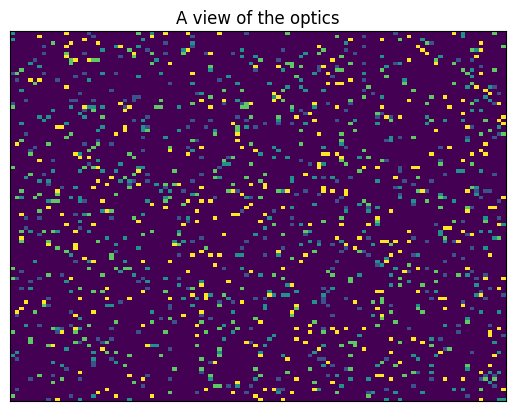

In [8]:
fig, ax = plt.subplots()
plot_grid(grid, ax)
ax.set_title('A view of the optics')

In [44]:
# ok working hypothesis is that the beam will eventually leave the grid
# it may end up in some sort of loop but we'll deal with that if it happens
NORTH = (-1, 0)
SOUTH = (1, 0)
EAST = (0, 1)
WEST = (0, -1)

slash = {
    NORTH: EAST,
    SOUTH: WEST,
    EAST: NORTH,
    WEST: SOUTH
}

back = {
    NORTH: WEST,
    SOUTH: EAST,
    EAST: SOUTH,
    WEST: NORTH
}

v_split = {
    NORTH: [NORTH],
    SOUTH: [SOUTH],
    EAST: [NORTH, SOUTH],
    WEST: [NORTH, SOUTH]
}

h_split = {
    NORTH: [EAST, WEST],
    SOUTH: [EAST, WEST],
    EAST: [EAST],
    WEST: [WEST]
}

@dataclass
class Beam:
    """stores all the points in a beam and if it's terminated"""
    vertices: list[tuple[int, int]]
    direction: tuple[int, int]
    terminated: bool = False

    @property
    def end(self) -> tuple[int, int]:
        """returns the current end of the beam"""
        return self.vertices[-1]

    @property
    def next_step(self) -> tuple[int, int]:
        """returns where the beam will go next"""
        self._next_step = tuple([
            value + offset for value, offset in zip(self.end, self.direction)])
        return self._next_step

    def propagate(self, tile: int|None) -> 'None|list[Beam, Beam]':
        """
        propagates the beam given the next tile - set tile to None if off grid

        Returns None if beam continues or two new beams if split
        """
        # if beam has left the grid
        if tile is None:
            self.terminated = True
            return None
        
        # else the next step must be valid so append it and then...
        self.vertices.append(self._next_step)
        if tile == EMPTY:
            return None
        elif tile == SLASH:
            self.direction = slash[self.direction]
            return None
        elif tile == BACK:
            self.direction = back[self.direction]
            return None
        elif tile == V_SPLIT:
            self.terminated = True
            return [
                Beam([self._next_step], direction)
                for direction in v_split[self.direction]
            ]
        elif tile == H_SPLIT:
            self.terminated = True
            return [
                Beam([self._next_step], direction)
                for direction in h_split[self.direction]
            ]
        else:
            raise ValueError(f'tile not recognised {tile=}, {self=}')
    
    @property
    def loc_and_dir(self) -> tuple[tuple[int]]:
        """returns the location and direction as a tuple of tuples"""
        return (self.end, self.direction)

    def plot(self, ax: plt.Axes, grid_height: int) -> None:
        """Adds a beam to the axis passed"""
        x, y = list(map(np.array, (zip(*self.vertices))))
        ax.plot(x + 0.5, grid_height - y - 1)

start_pos = (0, -1)
star_dir = EAST
beams = [Beam([start_pos], star_dir)]
checklist = []
while not all([beam.terminated for beam in beams]):
    print(f'{len(beams)=}', end='\r')
    new_beams = []
    # for each beam
    for beam in beams:
        # skip terminated beams
        if beam.terminated:
            continue

        # get where it would go next
        row, col = beam.next_step

        # check whether that's gone out of grid
        if not (0 <= row < len(grid)) or not (0 <= col < len(grid[0])):
            beam.propagate(None)
        else:
            result = beam.propagate(grid[row][col])

        # add beam status to the checklist and terminate if ones, ahem
        # beam there, done that haha
        loc_and_dir = beam.loc_and_dir
        if loc_and_dir in checklist:
            beam.propagate(None)
        else:
            checklist.append(loc_and_dir)

        # check the result - None for continuing, list of beams if splitting
        if result is None:
            continue
        else:
            new_beams.extend(result)
    beams.extend(new_beams)
        

My working hypothesis was incorrect. The beams do overlap so adding a check to ensure we don't recompute the same path more than once was required.

Text(0.5, 1.0, "Livin' the beam")

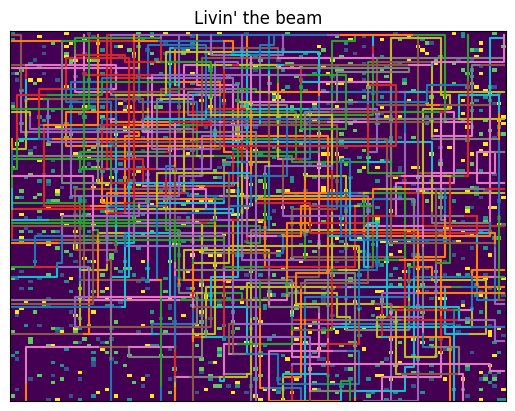

In [46]:
# lets see the beams!
fig, ax = plt.subplots()
plot_grid(grid, ax)
for beam in beams:
    beam.plot(ax, len(grid))
ax.set_title('Livin\' the beam')

In [47]:
# ok now let's solve!
covered_points = []
for beam in beams:
    for point in beam.vertices:
        if point not in covered_points:
            covered_points.append(point)

covered_points.pop(0)  # beam 0's first point is off grid!

(0, -1)

In [48]:
markdown(
    '### Solution',
    f'The number of tiles covered by the beam is {len(covered_points)}'
)

### Solution
The number of tiles covered by the beam is 7608